In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
import json
import os
import gzip
from math import log
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [3]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/pho4_chipexo_30min_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [4]:
max_lib2_keyToSeq = {}
max_rept_keyToSeq = {}
max_lib2_keyToDdG = {}
max_rept_keyToDdG = {}

In [5]:
!head data/experimental/lib2_mean_ddGs_excludedegenerate.csv

name,sequence,Pho4_mean_ddG,Max_mean_ddG
Rand_long1,CGCCCCAGCACTGCCAAGCCGACGTTAAAACGGGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTTGAGTGCATCGAATAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,0.0,0.0
GT_AC_45bp,CGCCCCAGCACTGCCAAGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTCACGTGACACACACACACACACACACACACACACACACACACACACACACACAAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,-0.6778106530502541,-0.13632404766909867
GC_GC_repeat,CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGTCACGTGACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCCGTCCGGCGGTATGAC,-0.6175501334109968,-0.6428362367973494
GC_AT_30+30+0,CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTATATATATATATATATATATATATATATACGTCCGGCGGTATGAC,-0.613228447720681,-0.6380198071302782
GA_CT_30+30+0,CGCGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCCTCTCTCTCTCTCTCTCTCTCTCTCTCTCTCGTCCGGCGGTATGAC,-0.175613341314786

In [6]:
!head data/experimental/lib1_mean_ddGs.csv

name,sequence,Pho4_mean_ddG,Max_mean_ddG
Motif_and_repeat_strong_5,CGCTGTGTGTGTGTGTGTCACGTGACACACACCACAAACGTCCGGCGGTATGAC,0.0,0.0
Motif_and_half_repeat_strong_12,CGCAAGGCTTGTGTGTGTCACGTGACACCACACATCGATGTCCGGCGGTATGAC,0.3894316305681954,-0.054177249724240414
CACGCG_RAND5,CGCACAGTCACTTAACGTCACGCGACCGGGGTATTTCAGGTCCGGCGGTATGAC,1.4670066671588076,1.3299561013868155
No_Motif_No_Repeat1,CGCCGCAGAGTCTCATTCTCCATACGCTGTAAAGTGGGAGTCCGGCGGTATGAC,1.728111359856401,1.434723755929844
Motif_and_repeat_strong_6,CGCATATATATATAGAGTCACGTGACTCTCGCGCGCGCGGTCCGGCGGTATGAC,0.17671646928607426,-0.1706078971117761
Motif_and_half_repeat_strong_14,CGCAGTGACGCGCAGAGTCACGTGACTCTATATTACGCTGTCCGGCGGTATGAC,0.7389271322412421,-0.10774786746869981
CACGCG_RAND8,CGCGATCGGCGCGGACGTCACGCGACCTCTAATTTTAAAGTCCGGCGGTATGAC,1.593243812268279,1.2099839444057396
No_Motif_No_Repeat2,CGCCCTGTCGGGAAAGACCATTGTTCTCTAAAGAGCTCGGTCCGGCGGTATGAC,1.8070692327794484,1.3918797069422961
Motif_and_repeat_strong_10,CGCTGTGTGTGTGTGTGTCACGTGACACACAA

In [7]:
firstLine = True
with open("data/experimental/lib2_mean_ddGs_excludedegenerate.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        max_lib2_keyToSeq[line.strip().split(',')[0]] = line.strip().split(',')[1]
        max_lib2_keyToDdG[line.strip().split(',')[0]] = float(line.strip().split(',')[-2])

In [8]:
firstLine = True
with open("data/experimental/lib1_mean_ddGs.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        max_rept_keyToSeq[line.strip().split(',')[0]] = line.strip().split(',')[1]
        max_rept_keyToDdG[line.strip().split(',')[0]] = float(line.strip().split(',')[-2])

In [13]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 546  #550
out_pred_len = 200
test_chrms = ["chrX", "chrXI"]
seq_peaks = []
with gzip.open("data/nexus/30min/1k_around_summits.bed.gz", 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 500#int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        seq_peaks.append(GenomeDict[chrm][start:end].upper())
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [14]:
def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]+insert+seq[flank+len(insert):]
    return new_seq

In [15]:
from deeplift.dinuc_shuffle import dinuc_shuffle
num_samples = 100
indices = np.random.choice(len(seq_peaks), num_samples, replace=False)
yvals_lib2 = {}
for key in max_lib2_keyToSeq:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, max_lib2_keyToSeq[key])
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict(getOneHot(pre_seqs))
    post = model.predict(getOneHot(post_seqs))
    yvals_lib2[key] = np.mean(post[0]-pre[0])

In [16]:
yvals_rept = {}
for key in max_rept_keyToSeq:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, max_rept_keyToSeq[key])
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict(getOneHot(pre_seqs))
    post = model.predict(getOneHot(post_seqs))
    #post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals_rept[key] = np.mean(post[0]-pre[0])

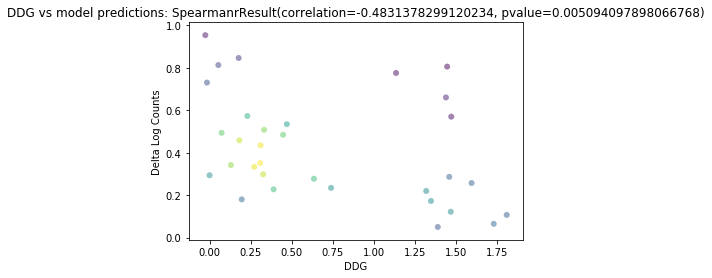

In [17]:
xvals = []
yvals = []
for key in max_rept_keyToSeq:
    yvals.append(yvals_rept[key])
    xvals.append(max_rept_keyToDdG[key])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

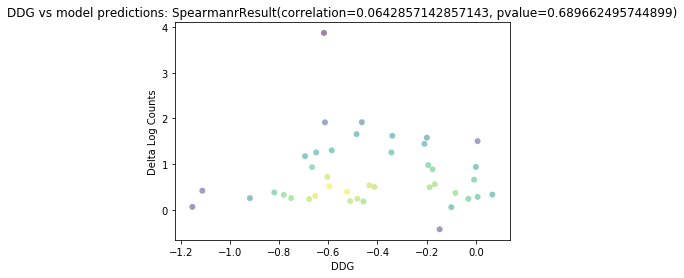

In [18]:
xvals = []
yvals = []
for key in max_lib2_keyToSeq:
    yvals.append(yvals_lib2[key])
    xvals.append(max_lib2_keyToDdG[key])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

In [ ]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

#See Google slide deck for explanations
#We meannorm as per section titled "Adjustments for Softmax Layers"
# in the DeepLIFT paper
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# this operation; we do this because we just want to treat the post-softmax
# probabilities as 'weights' on the different logits, without having the
# network explain how the probabilities themselves were derived
#Could be worth contrasting explanations derived with and without stop_gradient
# enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)
#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

In [ ]:
to_interpret = []
background = dinuc_shuffle(seq_peaks[idx])
max_rept_keyToSeq["background"] = ""
max_rept_keyToDdG["background"] = 1.5
for key in max_rept_keyToSeq:
    to_interpret.append(fill_into_center(pre_seq, max_rept_keyToSeq[key]))
preds = np.mean(model.predict([getOneHot(to_interpret), np.zeros((len(to_interpret),)), np.zeros((len(to_interpret),out_pred_len,2))])[0], axis = -1)
pred_profiles = model.predict([getOneHot(to_interpret), np.zeros((len(to_interpret),)), np.zeros((len(to_interpret),out_pred_len,2))])[1]

In [ ]:
xvals = []
for key in max_rept_keyToSeq:
    xvals.append(max_rept_keyToDdG[key])
    
xy = np.vstack([xvals,preds])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, preds, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, preds)))
plt.show()

In [ ]:
to_interpret = getOneHot(to_interpret)

In [ ]:
#The shap scores
post_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
    [to_interpret, np.zeros((len(to_interpret), 1))],
    progress_message=10)
post_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
    [to_interpret, np.zeros((len(to_interpret), out_pred_len, 2))],
    progress_message=10)

post_counts_actualimps = post_counts_hypimps*to_interpret
post_profile_actualimps = post_profile_hypimps*to_interpret

In [ ]:
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def smooth(vals):
    return np.convolve(vals, np.ones(1,)/1, mode='same')

for idx, key in enumerate(max_rept_keyToSeq.keys()):
    print("idx",idx)
    print("key",key)
    print("sequence",max_rept_keyToSeq[key])
    print("DDG",max_rept_keyToDdG[key])
    print("log count pred",preds[idx])
    
    for oneovertemp in [1.0]:
        print("oneovertemp",oneovertemp)
        print(pred_profiles[idx].shape)
        print("Pred profile shape", pred_profiles[idx].shape)
        pred_profile = preds[idx] *(np.exp(pred_profiles[idx]*oneovertemp)/
                                    np.sum(np.exp(pred_profiles[idx]*oneovertemp),axis=0)[None,:])   
        plt.figure(figsize=(20,2))

        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        plt.show()

    print("counts imp")
    viz_sequence.plot_weights(post_counts_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)
    print("profile imp")
    viz_sequence.plot_weights(post_profile_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)

In [ ]:
for idx, key in enumerate(max_rept_keyToSeq.keys()):
    print("idx",idx)
    print("key",key)
    print("sequence",max_rept_keyToSeq[key])
    print("DDG",max_rept_keyToDdG[key])
    print("log count pred",preds[idx])
    
    for oneovertemp in [1.0]:
        print("oneovertemp",oneovertemp)
        print(pred_profiles[idx].shape)
        print("Pred profile shape", pred_profiles[idx].shape)
        pred_profile = preds[idx] *(np.exp(pred_profiles[idx]*oneovertemp)/
                                    np.sum(np.exp(pred_profiles[idx]*oneovertemp),axis=0)[None,:])   
        plt.figure(figsize=(20,2))

        start_view = 500
        end_view = 800
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        plt.show()

    print("counts imp")
    viz_sequence.plot_weights(post_counts_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)
    print("profile imp")
    viz_sequence.plot_weights(post_profile_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)

In [19]:
f = open('data/preds/nexus_pho4_30mins_lib2_preds.csv','w')
for key in max_lib2_keyToSeq:
    if key == 'background': continue
    f.write(key+','+max_lib2_keyToSeq[key]+','+str(yvals_lib2[key])+'\n')
f.close()
!head data/preds/max_hela_1_lib2_preds.csv
f = open('data/preds/nexus_pho4_30mins_rept_preds.csv','w')
for key in max_rept_keyToSeq:
    if key == 'background': continue
    f.write(key+','+max_rept_keyToSeq[key]+','+str(yvals_rept[key])+'\n')
f.close()
!head data/preds/max_hela_1_rept_preds.csv

Rand_long1,CGCCCCAGCACTGCCAAGCCGACGTTAAAACGGGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTTGAGTGCATCGAATAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,0.35982284
GT_AC_45bp,CGCCCCAGCACTGCCAAGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTCACGTGACACACACACACACACACACACACACACACACACACACACACACACAAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,0.1504052
GC_GC_repeat,CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGTCACGTGACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCCGTCCGGCGGTATGAC,0.15909371
GC_AT_30+30+0,CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTATATATATATATATATATATATATATATACGTCCGGCGGTATGAC,0.39176002
GA_CT_30+30+0,CGCGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCCTCTCTCTCTCTCTCTCTCTCTCTCTCTCTCGTCCGGCGGTATGAC,0.2882929
GT_scrambled_7,CGCTGGTTTGGTTTGTGGGTGGGGTTTGTTTTGGTGTTTGTTGTGGGTGGTTTGGGTGGGGTTGTCACGTGACAACCCCACCCAAACCACCCACAACAAACACCAAAACAAACCCCACC